In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 材料参数
G0 = 1.0       # 弹性模量
tau = 1.0      # 松弛时间

# 时间参数
t_start = 0.0
T=2*np.pi
t_end = 4*T
num_points = 1000
time = np.linspace(t_start, t_end, num_points)
dt = time[1] - time[0]

# 剪切应变函数
gamma0 = 2   # 应变幅值
omega = 2*np.pi/T
gamma = gamma0 * np.sin(omega * time)

# 初始化应力分量
sigma11 = np.zeros_like(time)
sigma22 = np.zeros_like(time)
sigma12 = np.zeros_like(time)

# 数值积分计算应力
for i, t in enumerate(time):
    for j in range(i):
        t_prime = time[j]
        gamma_diff = gamma[i] - gamma[j]
        exp_term = np.exp(-(t - t_prime) / tau)
        
        # 取向张量函数 Q
        Q11 = (1 + gamma_diff**2) / (2 + gamma_diff**2)
        Q12 = gamma_diff / (2 + gamma_diff**2)
        Q22 = 1 / (2 + gamma_diff**2)
        
        # 应力积分
        sigma11[i] += G0 * exp_term * Q11 * dt
        sigma22[i] += G0 * exp_term * Q22 * dt
        sigma12[i] += G0 * exp_term * Q12 * dt*20

# 计算第一法向应力差
N1 = sigma11 - sigma22



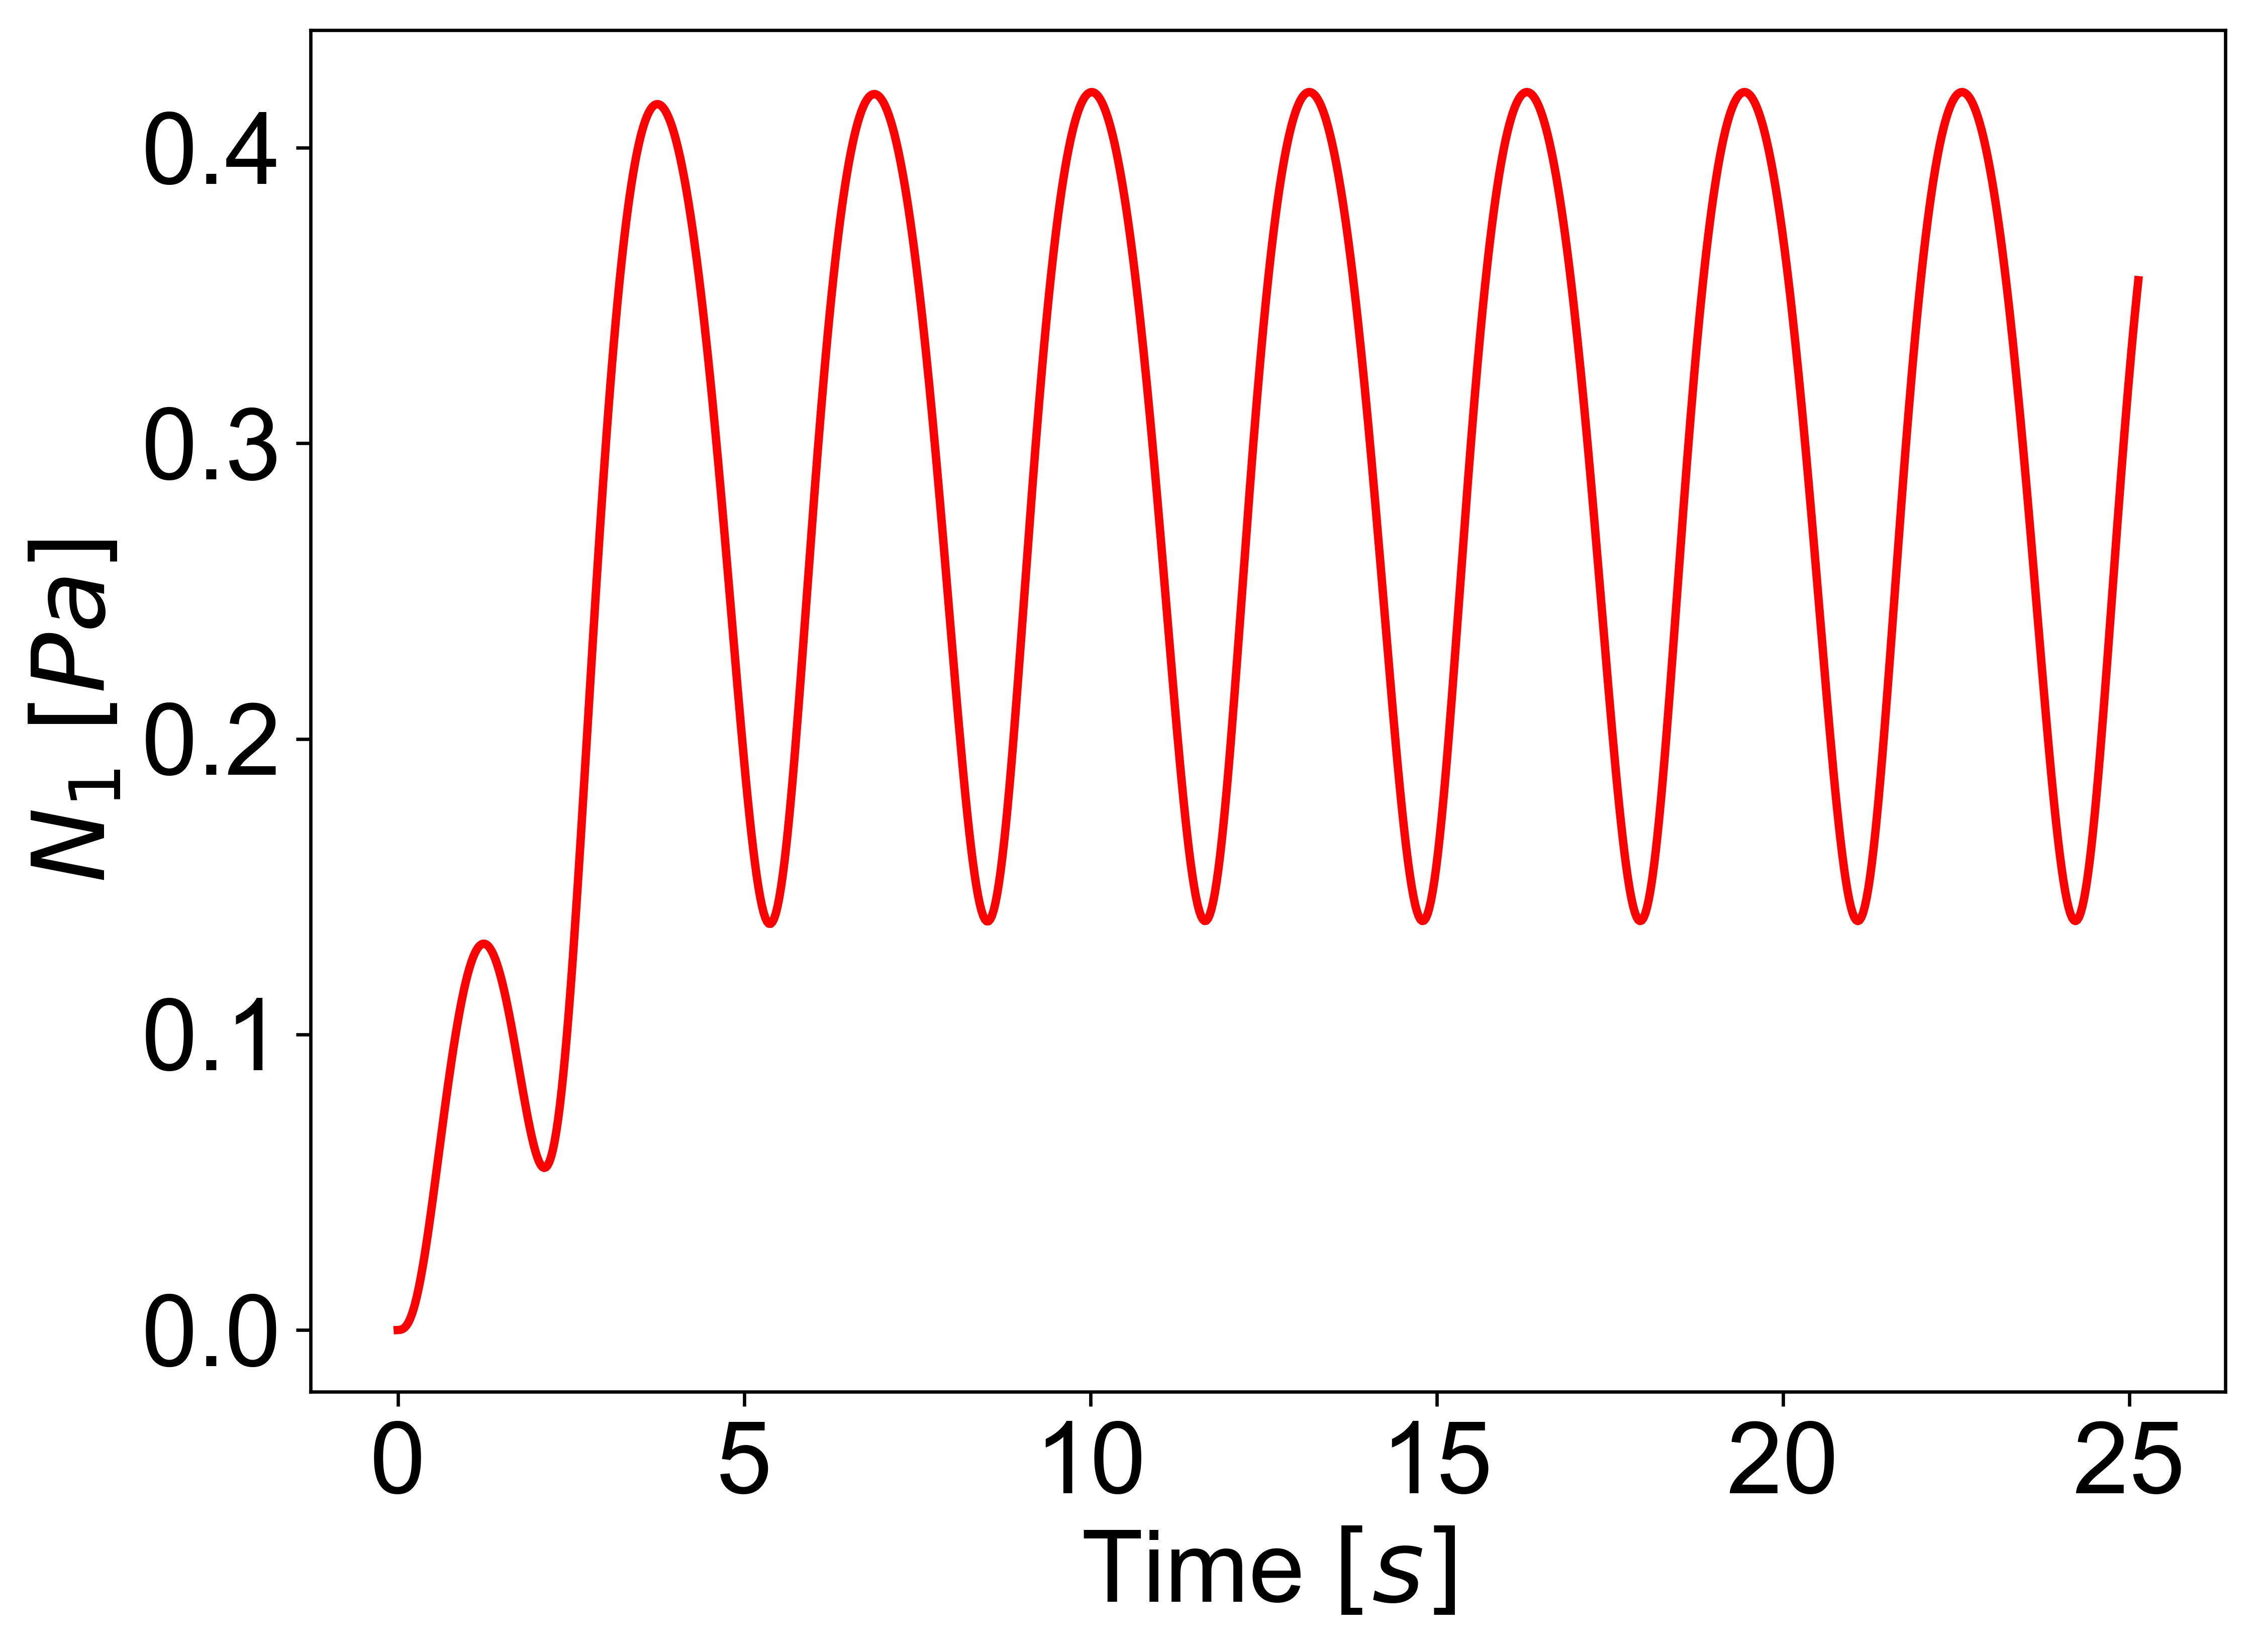

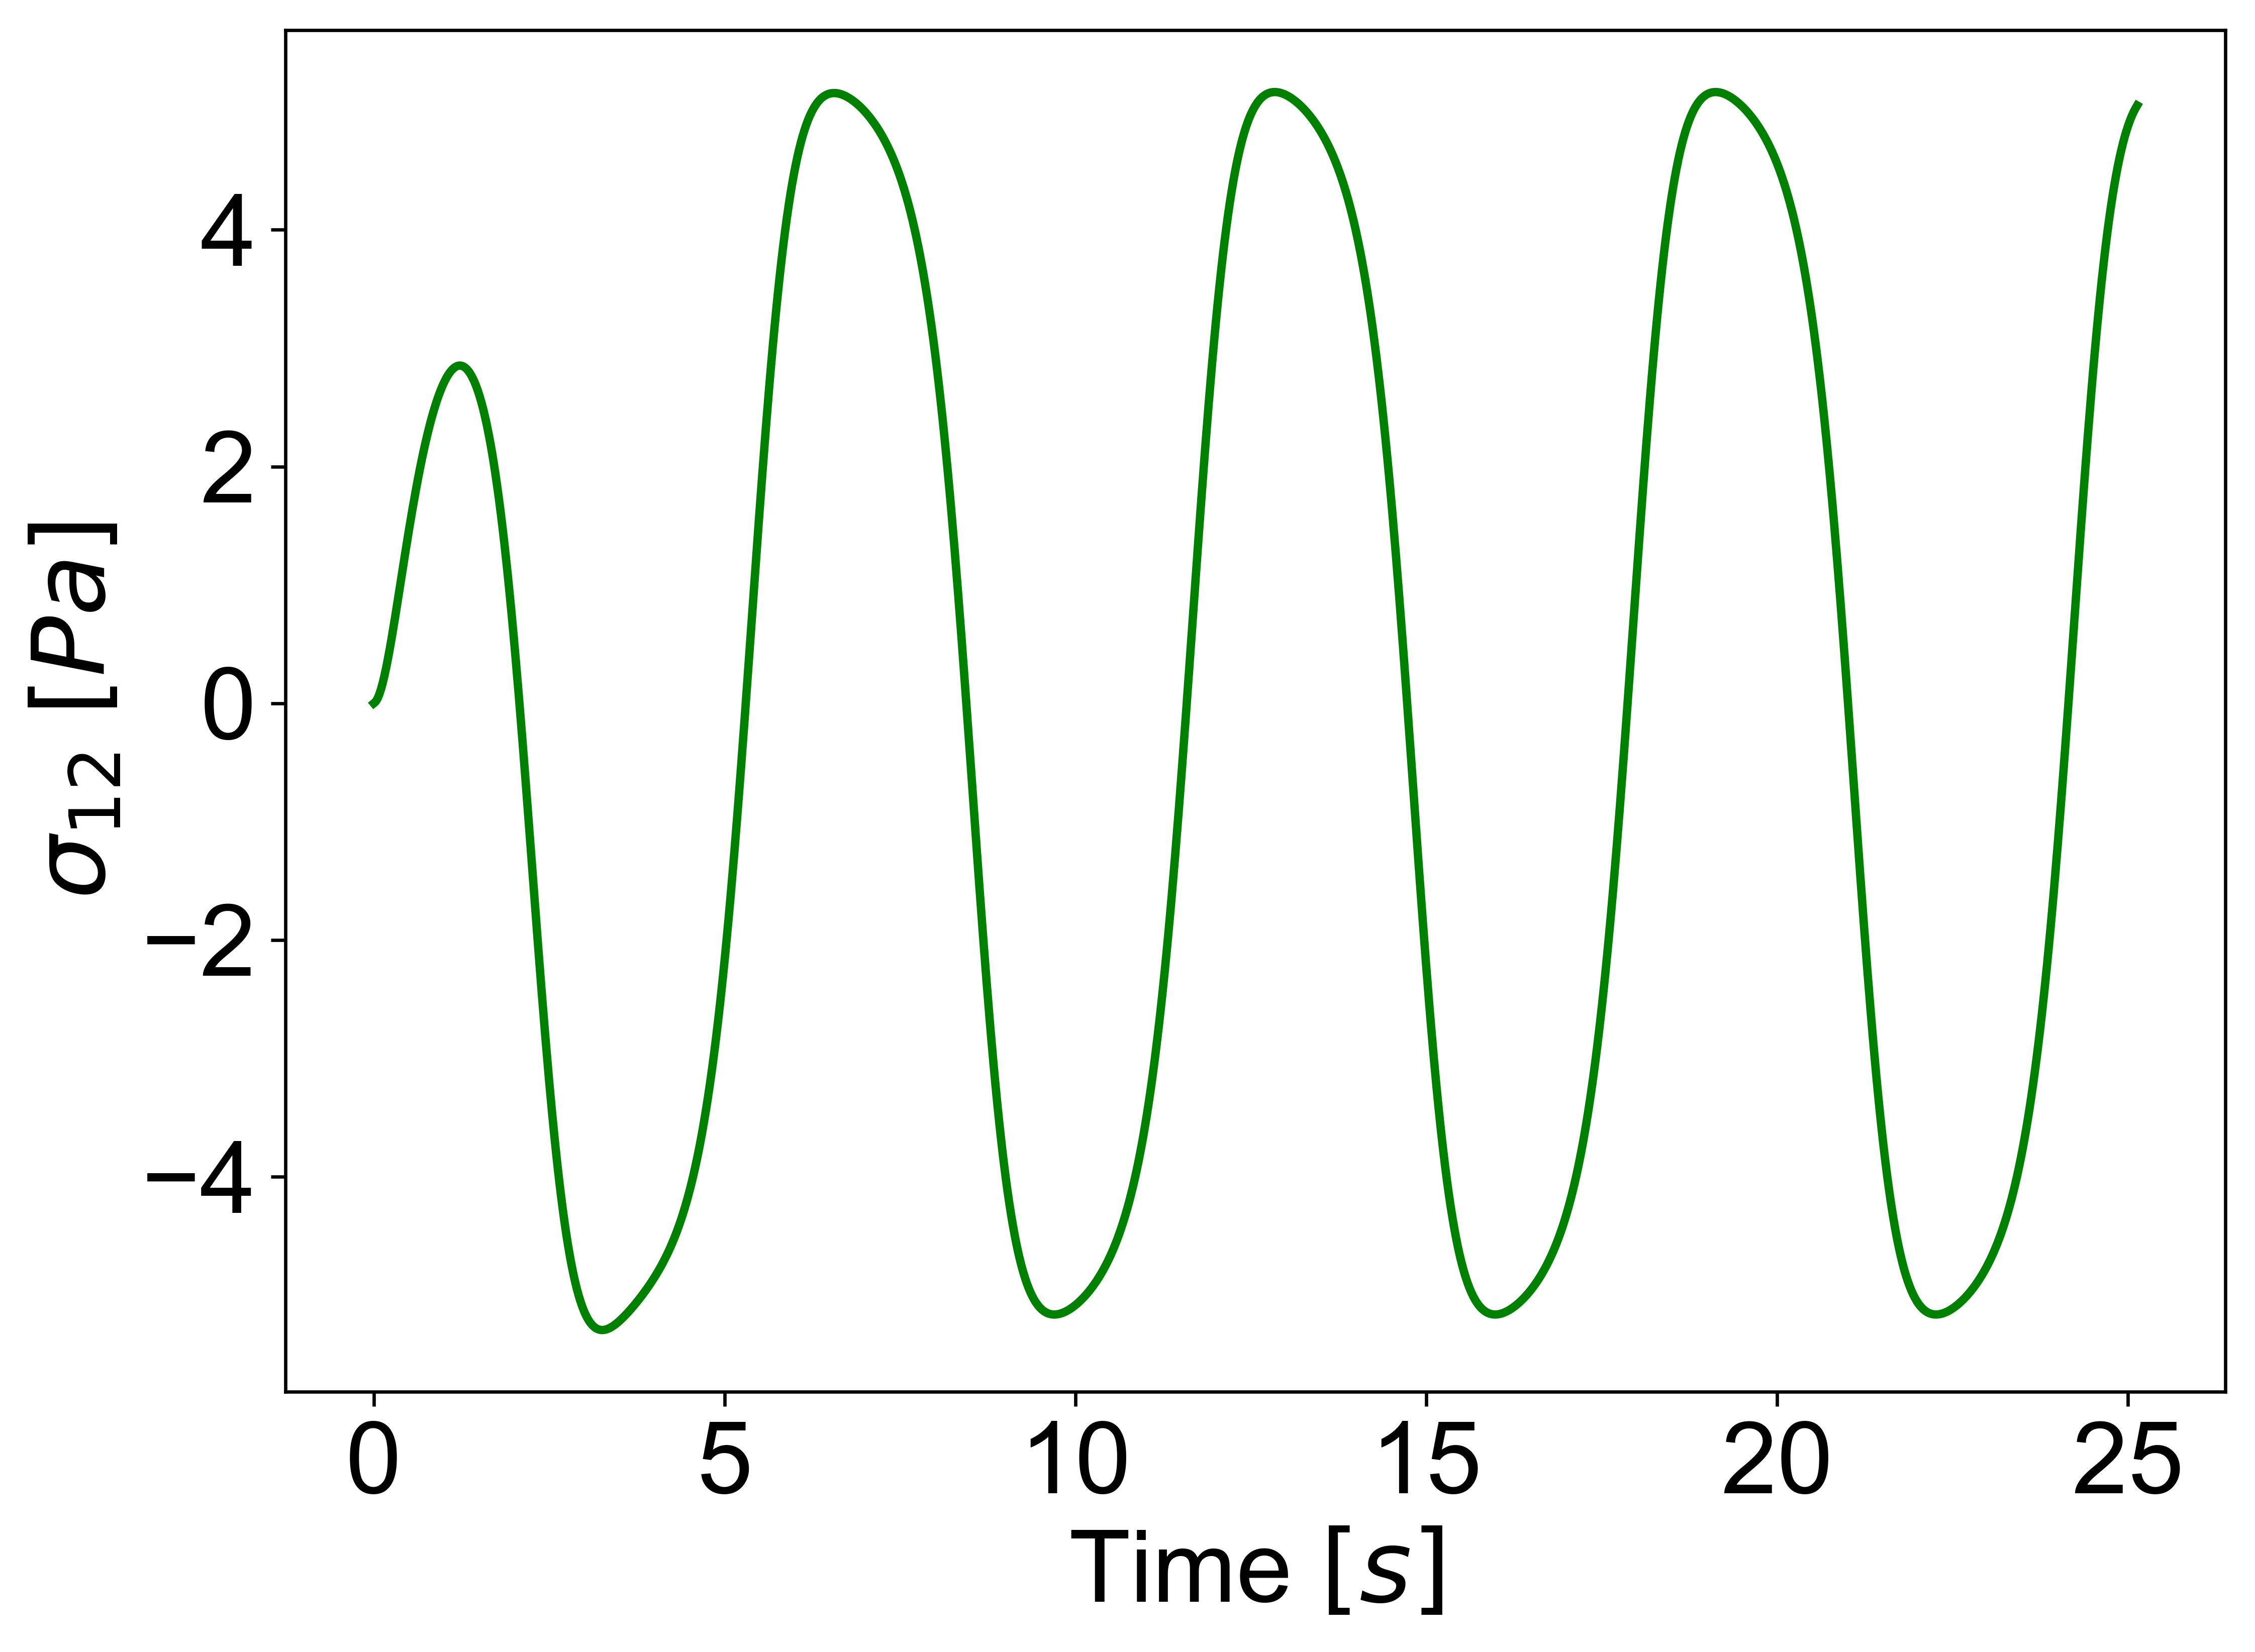

In [49]:
# 设置全局字体为 Arial，字号为 24
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24


# 图 1: 第一法向应力差 N1 随时间的变化
plt.figure(figsize=(8, 6),dpi=600)  # 画布大小为 8x6 英寸
plt.plot(time, N1, color='r', linewidth=2)
plt.xlabel('Time $[s]$')
plt.ylabel('$N_{1}$ $[Pa]$')
plt.tight_layout()
#plt.savefig("N1_vs_Time.png", dpi=600)  # 保存为高分辨率图片
plt.show()

# 图 3: 剪切应力 σ12 随时间的变化
plt.figure(figsize=(8, 6),dpi=600)  # 画布大小为 8x6 英寸
plt.plot(time, sigma12, color='g', linewidth=2)
plt.xlabel('Time $[s]$')
plt.ylabel('$\sigma_{12}$ $[Pa]$')
plt.tight_layout()
#plt.savefig("Shear_Stress_vs_Time.png", dpi=600)  # 保存为高分辨率图片
plt.show()

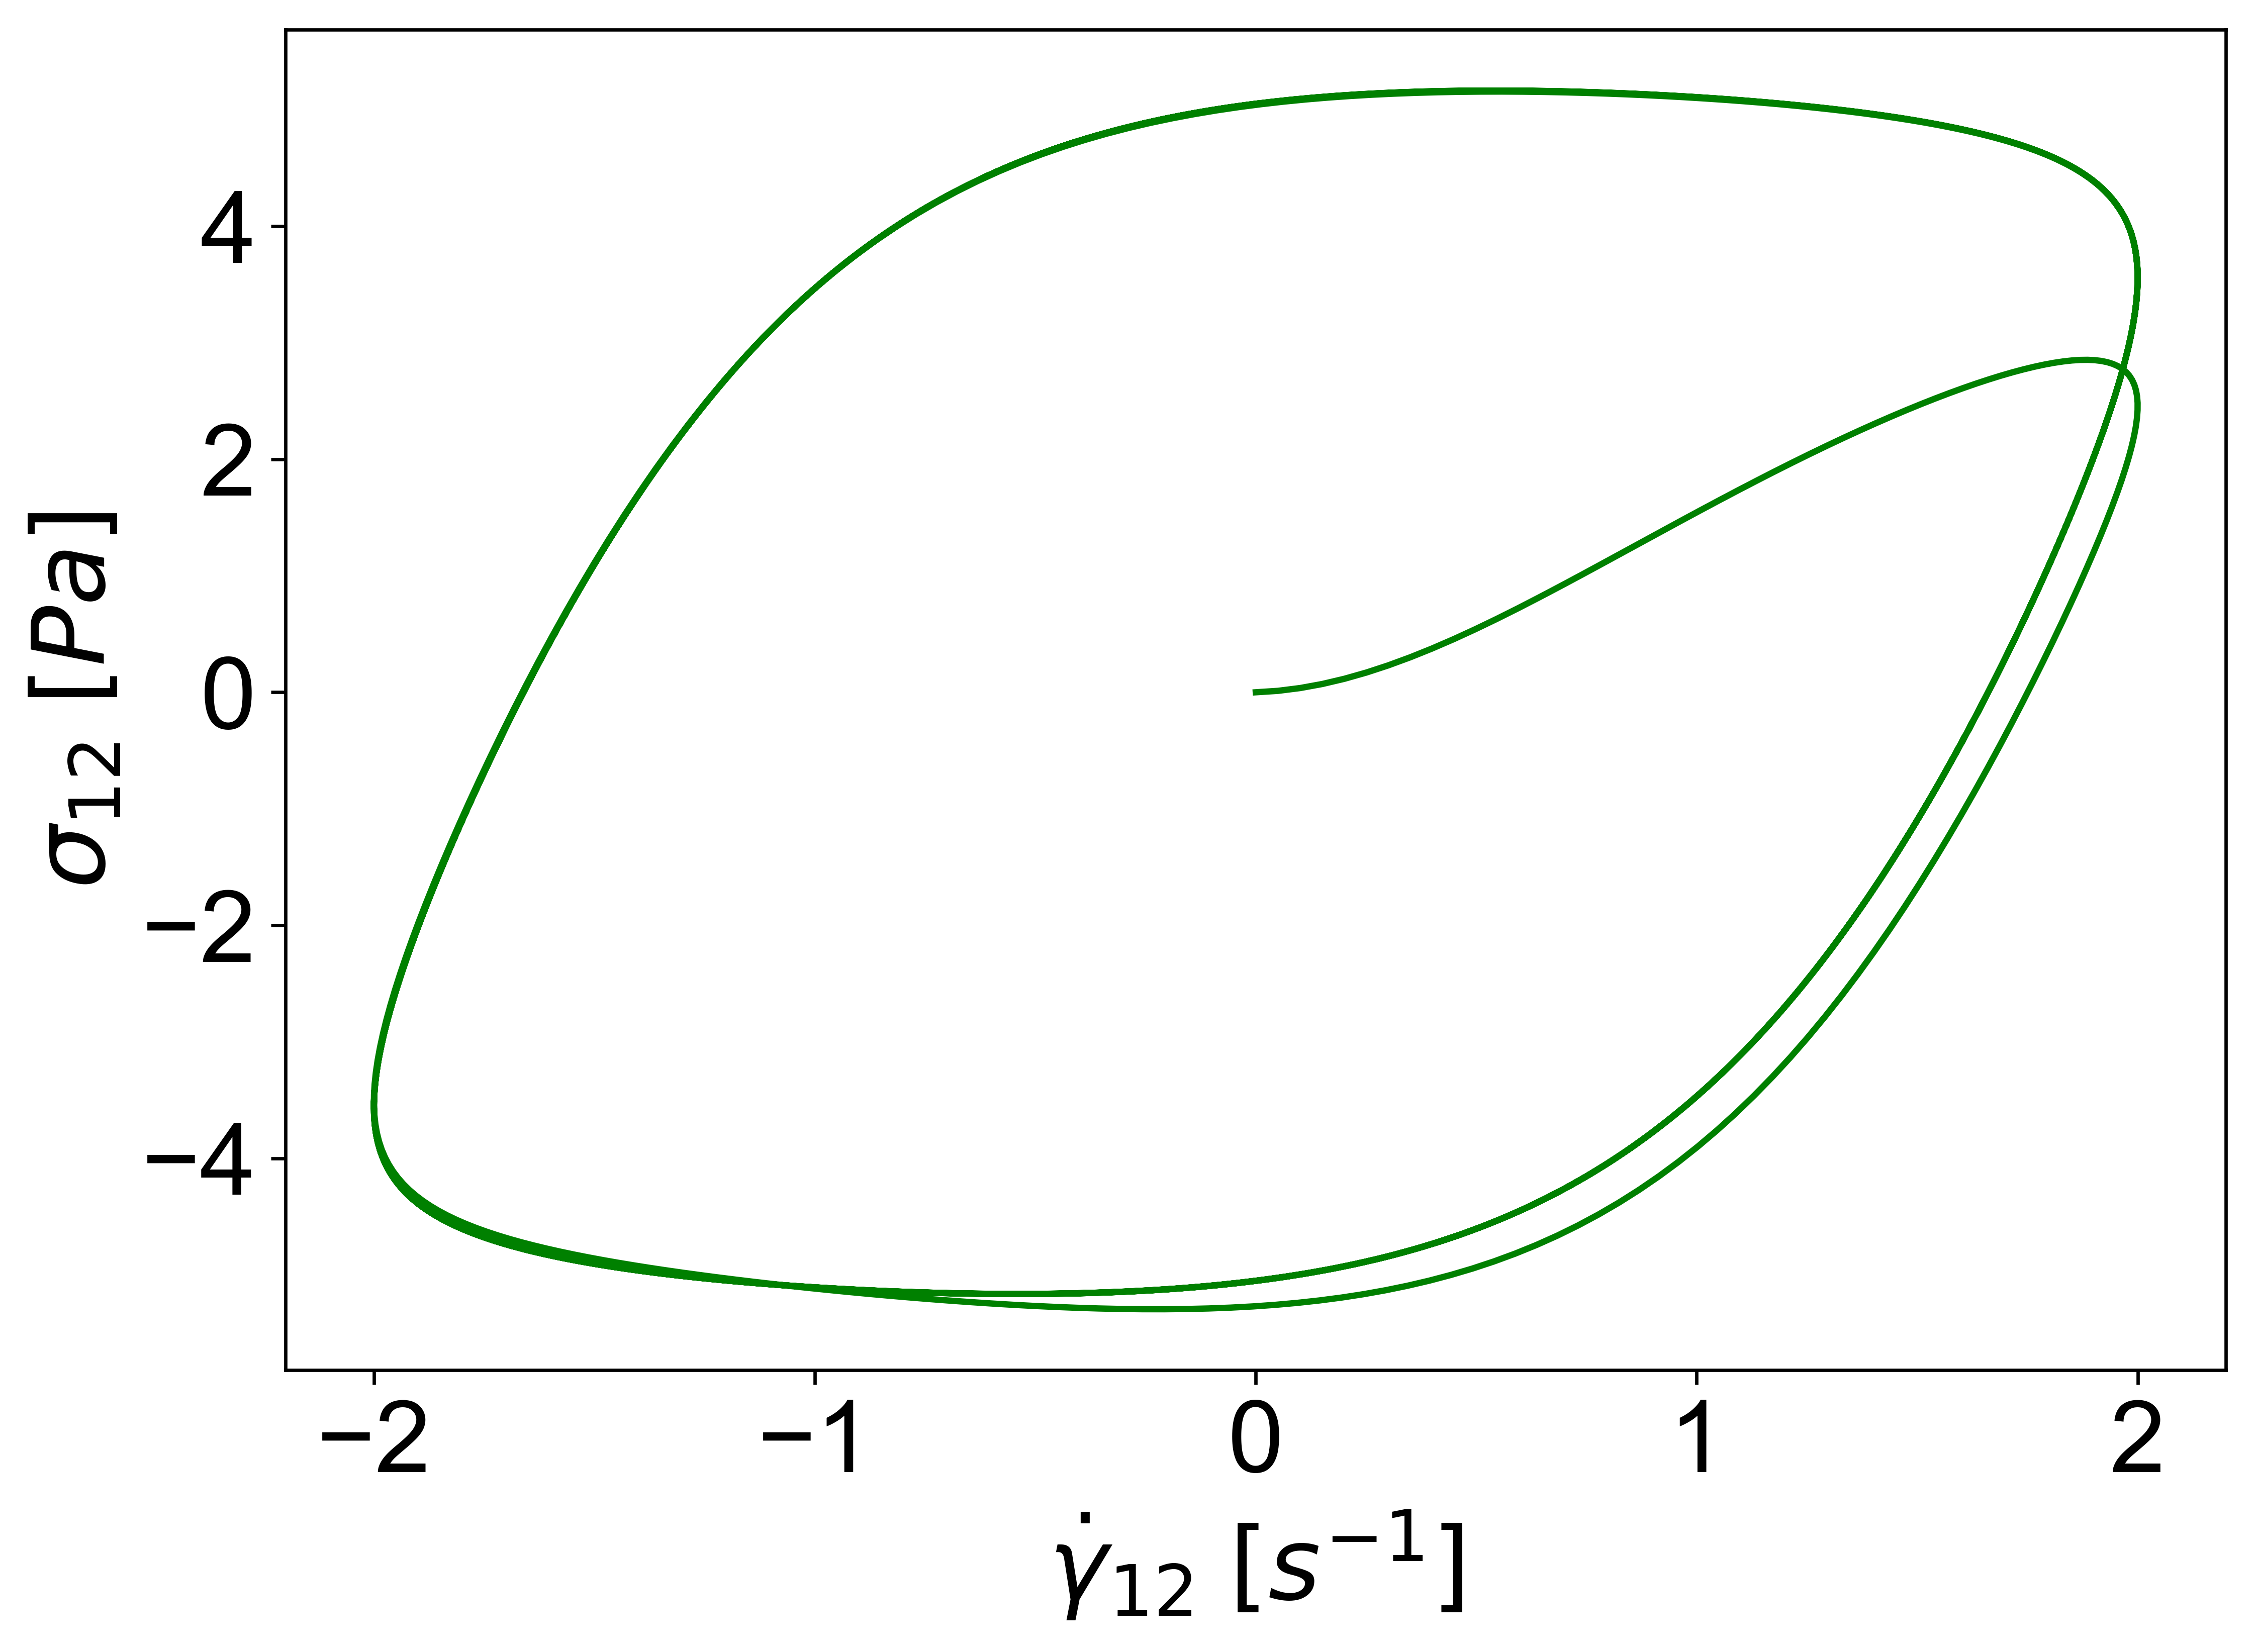

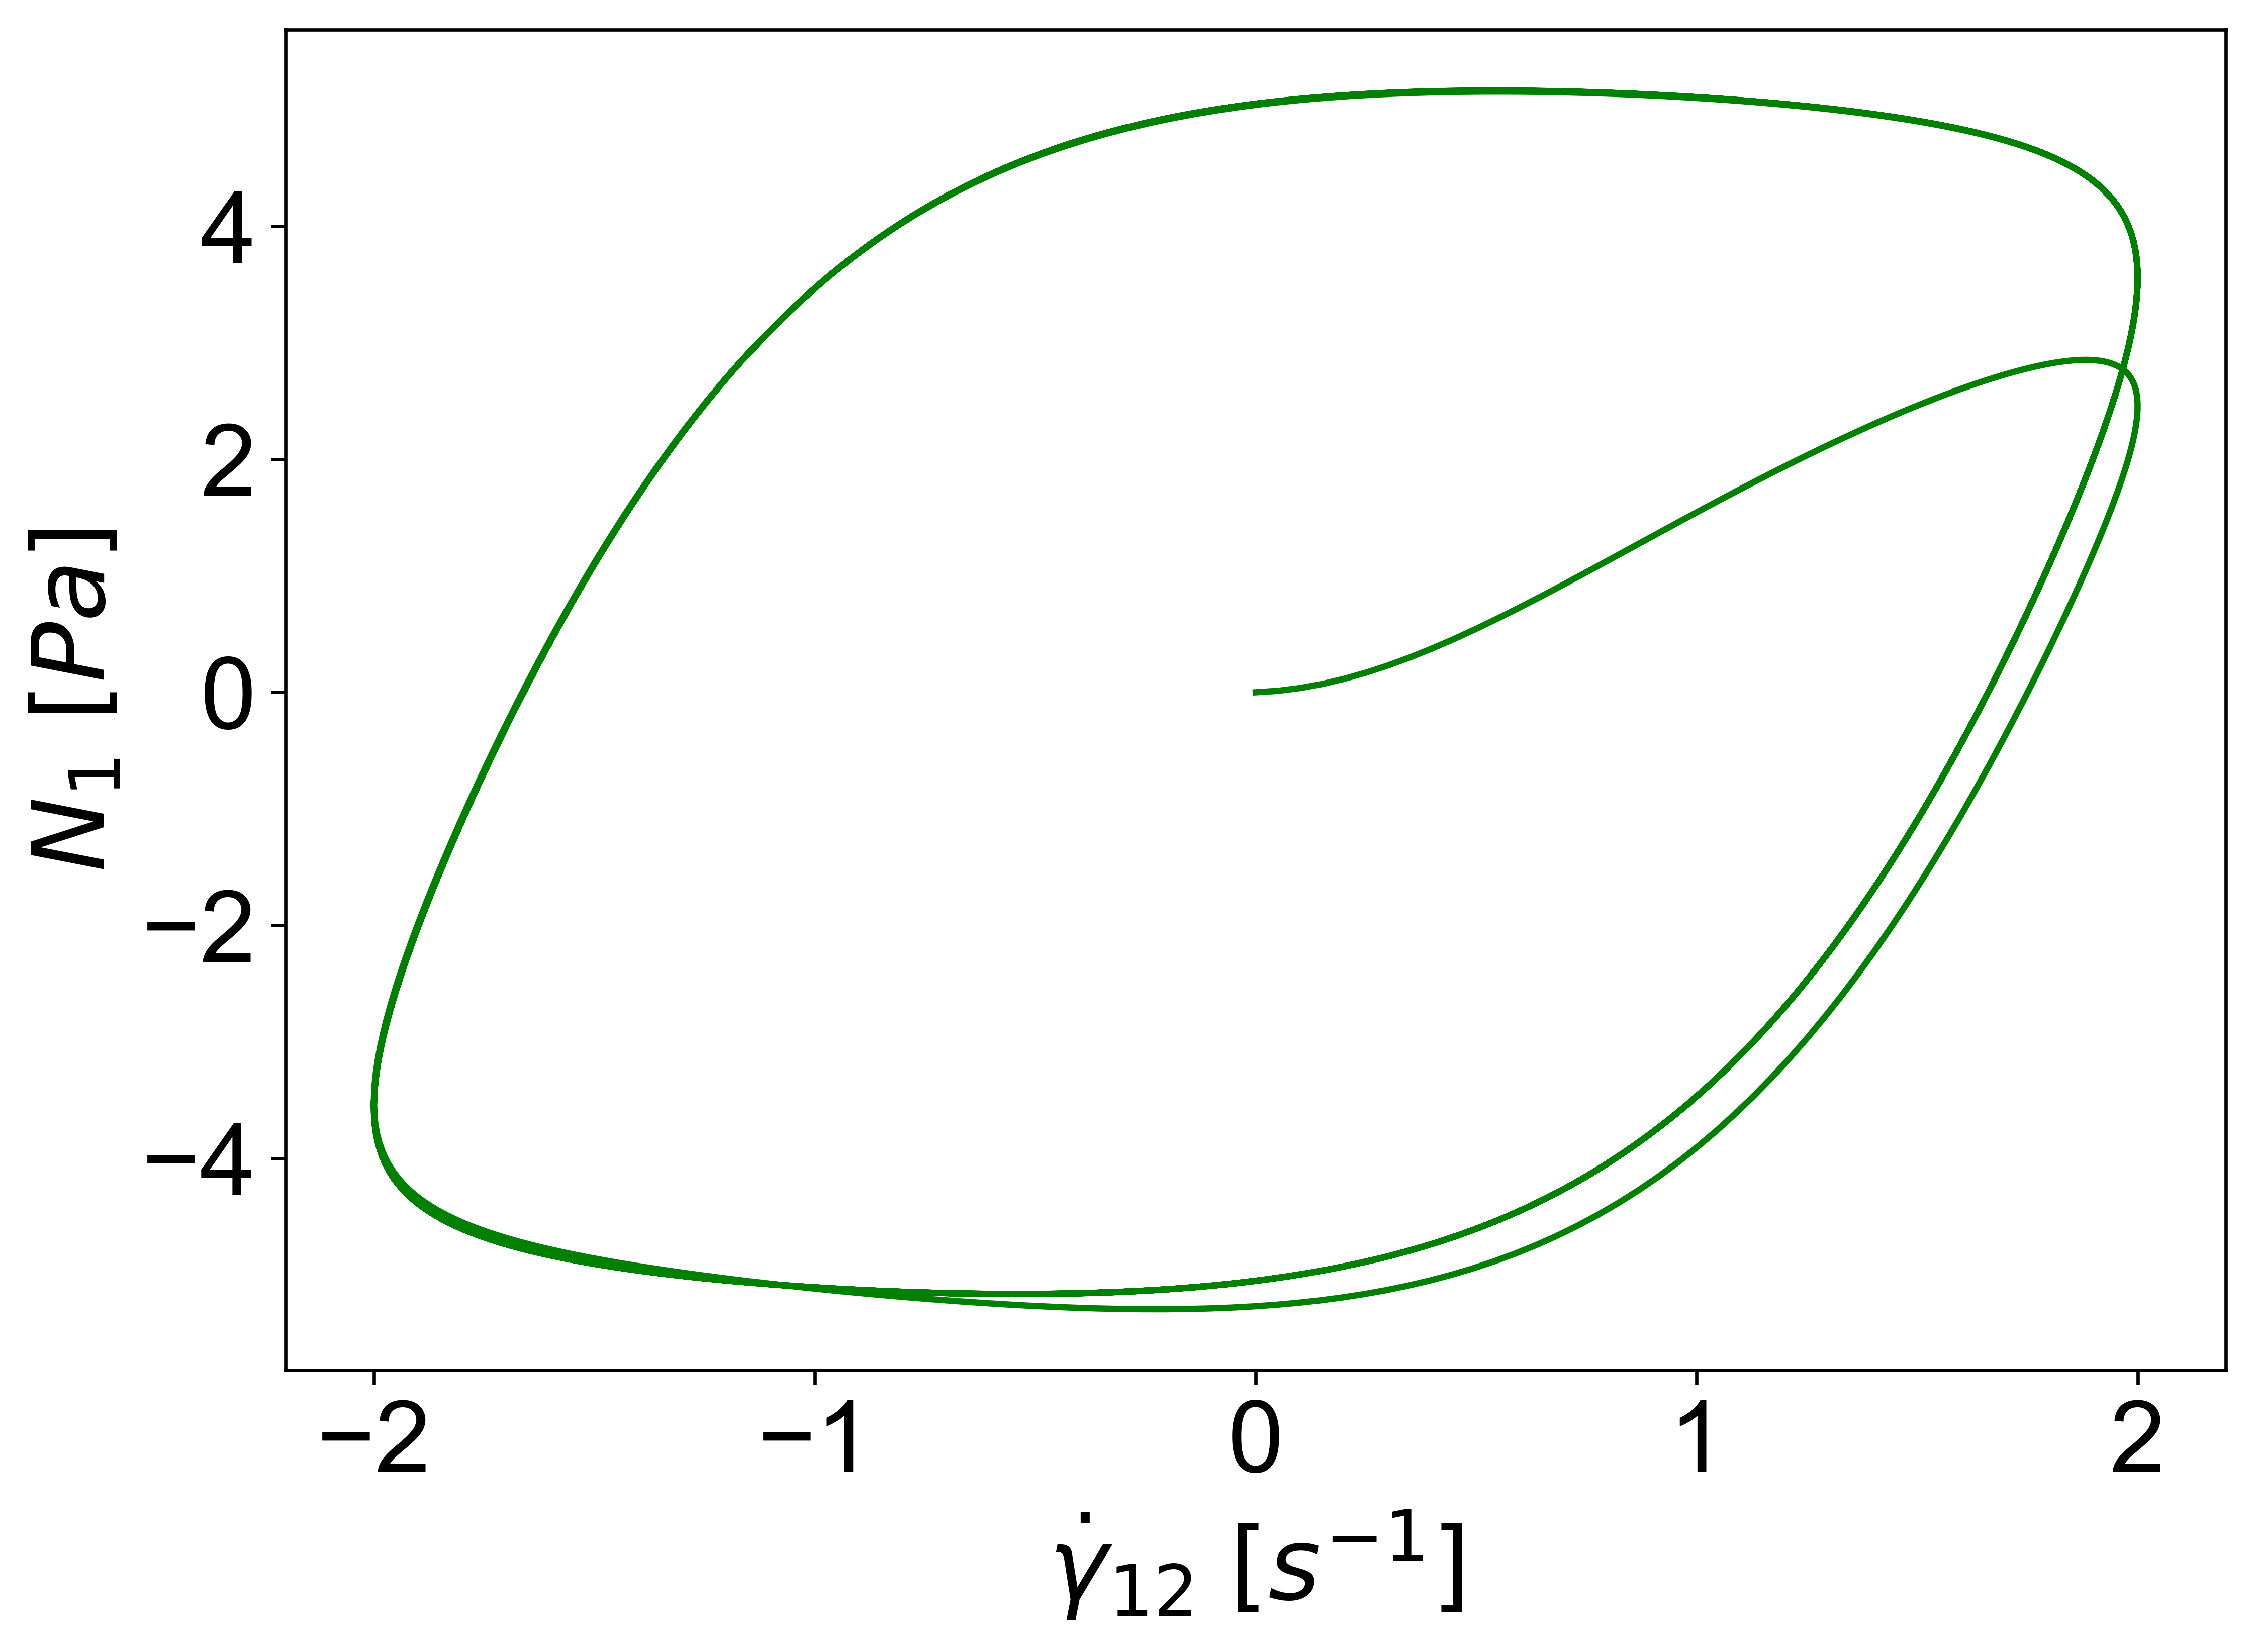

In [50]:
# 绘制σ12 随剪切应变 γ 的变化
plt.figure(figsize=(8, 6),dpi=600)
plt.plot(gamma, sigma12, color='g')
plt.xlabel('$\dot{\gamma}_{12}$ $[s^{-1}]$')
plt.ylabel('$\sigma_{12}$ $[Pa]$')
plt.tight_layout()
plt.show()

# 绘制 N1 随剪切应变 γ 的变化
plt.figure(figsize=(8, 6),dpi=600)
plt.plot(gamma, sigma12, color='g')
plt.xlabel('$\dot{\gamma}_{12}$ $[s^{-1}]$')
plt.ylabel('$N_{1}$ $[Pa]$')
plt.tight_layout()
plt.show()